In [ ]:
from transformers import AutoImageProcessor, AutoModel, AutoConfig
vision_config = AutoConfig.from_pretrained("facebook/dinov2-small")
print(vision_config)

Dinov2Config {
  "apply_layernorm": true,
  "architectures": [
    "Dinov2Model"
  ],
  "attention_probs_dropout_prob": 0.0,
  "drop_path_rate": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 518,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-06,
  "layerscale_value": 1.0,
  "mlp_ratio": 4,
  "model_type": "dinov2",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "out_features": [
    "stage12"
  ],
  "out_indices": [
    12
  ],
  "patch_size": 14,
  "qkv_bias": true,
  "reshape_hidden_states": true,
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4",
    "stage5",
    "stage6",
    "stage7",
    "stage8",
    "stage9",
    "stage10",
    "stage11",
    "stage12"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "use_mask_token": true,
  "use_swiglu_ffn": false
}

Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "b

In [ ]:
from transformers import AutoImageProcessor, AutoModel, AutoConfig
llm_config = AutoConfig.from_pretrained("google/gemma-3-4b-it")
print(llm_config.text_config)

Gemma3TextConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": null,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "final_logit_softcapping": null,
  "head_dim": 256,
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2560,
  "initializer_range": 0.02,
  "intermediate_size": 10240,
  "max_position_embeddings": 131072,
  "model_type": "gemma3_text",
  "num_attention_heads": 8,
  "num_hidden_layers": 34,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_local_base_freq": 10000.0,
  "rope_scaling": {
    "factor": 8.0,
    "rope_type": "linear"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 1024,
  "sliding_window_pattern": 6,
  "transformers_version": "4.51.3",
  "use_cache": true,
  "vocab_size": 262208
}



In [2]:
from transformers import AutoProcessor, AutoModel, AutoConfig

/Users/seungwoo/anaconda3/envs/sur/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from typing import Optional, Union, Dict
from torch.utils.data import Dataset
import torch
import pandas as pd
from PIL import Image
import numpy as np

class QuIC360Dataset(Dataset):
    def __init__(self, 
                 csv_file: str,
                 model_name: str = "Salesforce/blip2-opt-2.7b",
                 image_size: list = [224,224],
                 max_length: Optional[int] = None,
                 split: str = "train",
                 do_crop: bool = False,
                 patch_size: Optional[tuple] = None,
                 overlap_ratio: Optional[float] = None,
                 fov: Optional[float] = None,
                 transform: bool = False):
        """
        Args:
            csv_file (str): 이미지 경로와 Q&A 정보가 담긴 CSV 파일 경로
            model_name (str): HuggingFace AutoProcessor를 불러올 모델명
            image_size (list): do_crop=False인 경우 Processor가 기대하는 리사이즈 크기 (H, W)
            max_length (int): 텍스트 입력 최대 길이
            split (str): 데이터 분할정보 (train/val 등)
            do_crop (bool): 슬라이딩 윈도우 적용 여부
            patch_size (tuple, optional): 슬라이딩 윈도우 높이/너비(px) (patch_h, patch_w).
                                          fov가 지정되면 patch_w는 fov 기반으로 덮어써진다.
            overlap_ratio (float, optional): 패치 간 겹침 비율 (0.0 ~ 1.0)
            fov (float, optional): “한 패치의 시야각(FOV)”을 도 단위로 지정.
                                  예: fov=90 → 패치 너비 = W4 * (90/360)
            transform (bool): 이미지 전처리 추가 시 사용 (추후 확장용)
        """
        super().__init__()
        
        self.df = pd.read_csv(csv_file)
        self.processor = AutoProcessor.from_pretrained(model_name)
        
        self.max_length = max_length
        self.split = split
        self.do_crop = do_crop
        
        # (1) 슬라이딩 윈도우 높이(patch_h) 및 기본 너비(patch_w) 지정
        #    - patch_size가 None이면 image_size를 기본으로 사용
        #    - fov가 지정되면 patch_w는 fov 기반으로 덮어써진다
        self.patch_size = patch_size if patch_size is not None else tuple(image_size)
        self.overlap_ratio = overlap_ratio if overlap_ratio is not None else 0.0
        self.fov = fov  # 도 단위. ex) 90.0
        
        if self.do_crop:
            # do_crop=True일 때는 실제 이미지 크기 기준으로 슬라이딩 윈도우 적용
            pass
        else:
            # do_crop=False → Processor가 기대하는 크기로 리사이즈
            self.image_size = tuple(image_size)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, str]]:
        # 1) CSV에서 이미지 경로, 질문, 정답 추출
        image_path = self.df.iloc[idx]["url"]
        question   = str(self.df.iloc[idx]["query"])
        answer     = str(self.df.iloc[idx]["annotation"])
        
        # 2) 원본 equirectangular 이미지 로드 → (C, H2, W4) 형태로 변환
        image = Image.open(image_path).convert("RGB")
        img_tensor = self._pil_to_tensor(image)  # (C, H2, W4), 값 [0,1]
        
        # 3) 슬라이딩 윈도우 파라미터 계산
        H2, W4 = img_tensor.shape[1], img_tensor.shape[2]
        
        # (1) 패치 높이 = patch_size[0]
        patch_h = self.patch_size[0]
        # (2) 패치 너비 = fov가 있으면 W4*(fov/360), 없으면 patch_size[1]
        if self.fov is not None:
            patch_w = int(W4 * (self.fov / 360.0))
        else:
            patch_w = self.patch_size[1]
        
        # (3) 겹침 비율 → stride 계산
        stride_h = max(int(patch_h * (1.0 - self.overlap_ratio)), 1)
        stride_w = max(int(patch_w * (1.0 - self.overlap_ratio)), 1)
        
        # 4) 상·하단 H2//4 영역 제외를 위한 y 범위 계산
        #    상단 절사 시작 y_min = ceil(H2/4)
        y_min = int(np.ceil(H2 / 4.0))
        #    하단 절사 경계: y + patch_h ≤ H2 - floor(H2/4) 이어야
        y_max = int(H2 - np.floor(H2 / 4.0) - patch_h)
        
        if y_max < y_min:
            # 중앙 50% 영역이 patch_h보다 작으면 빈 컬렉션
            patches_tensor = torch.zeros((0, 3, patch_h, patch_w))
        else:
            patches = []
            # 5) y축: y_min ≤ y ≤ y_max, step = stride_h
            for y in range(y_min, y_max + 1, stride_h):
                # x축: 0 ≤ x < W4, step = stride_w
                for x in range(0, W4, stride_w):
                    if x + patch_w <= W4:
                        # 일반적으로 우측 넘어가지 않는 경우
                        patch = img_tensor[:, y : y + patch_h, x : x + patch_w]
                    else:
                        # 가로 래핑: 우측 일부 + 좌측 일부 병합
                        right_part = img_tensor[:, y : y + patch_h, x : W4]
                        left_part  = img_tensor[:, y : y + patch_h, 0 : (x + patch_w) - W4]
                        patch = torch.cat([right_part, left_part], dim=2)
                    patches.append(patch)
            
            # (N, C, patch_h, patch_w) 형태로 변환
            patches_tensor = torch.stack(patches, dim=0)
            # → shape: (num_patches=N, C, patch_h, patch_w)
        
        # 6) Processor에 질문(text)과 패치들(images)을 전달하여 입력 텐서 생성
        #    - images는 4차원 텐서(N, C, H, W) 형태여야 한다.
        inputs = self.processor(
            text=question,
            images=patches_tensor,  
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        # 8) 최종 반환
        return {
            "pixel_values":   inputs["pixel_values"],    # (N, C, H, W)
            "input_ids":      inputs["input_ids"].squeeze(0),     # (L1)
            "attention_mask": inputs["attention_mask"].squeeze(0),# (L1)
            "labels":         inputs["input_ids"].squeeze(0),                      # (L2)
            "image_path":     image_path,
            "question":       question,
            "answer":         answer
        }
    
    def _pil_to_tensor(self, pil_img: Image.Image) -> torch.Tensor:
        """
        PIL.Image → torch.Tensor (C, H, W) 변환. 픽셀 값 [0,1]로 정규화.
        """
        arr = torch.from_numpy(np.array(pil_img)).permute(2, 0, 1).float() / 255.0
        return arr
    
    

## DINOv2 시각화(테스트용)

#### 무변환 패치 자르기

In [12]:
import torch
import numpy as np
from PIL import Image

def extract_sliding_patches(
    pil_img: Image.Image,
    fov: float,
    overlap_ratio: float
) -> torch.Tensor:
    """
    Args:
        pil_img (PIL.Image.Image): 입력 equirectangular 파노라마 이미지
        fov (float): 한 패치의 시야각(FOV, degree 단위). ex) 90.0
        overlap_ratio (float): 패치 간 겹침 비율 (0.0 ~ 1.0)

    Returns:
        torch.Tensor: (N, C, patch_h, patch_w) 형태의 패치 텐서 모음
    """
    # 1) PIL → Torch 텐서 변환 (C, H2, W4), 값 범위 [0,1]
    img_arr = np.array(pil_img)                              # (H2, W4, 3)
    img_tensor = torch.from_numpy(img_arr).permute(2, 0, 1).float() / 255.0
    # → (C=3, H2, W4)

    C, H2, W4 = img_tensor.shape

    # 2) 패치 높이(patch_h)와 패치 너비(patch_w) 계산
    #    (예시에서는 patch_h를 H2/4로 가정 가능하나, 원본 코드는 외부에서 지정됨)
    #    여기서는 단순히 “중앙 영역 높이”를 patch_h로 사용한다고 가정
    patch_h = int(np.floor(H2 / 2.0))  # 예: 중앙 50% 높이만 사용하기 위한 임시 값
    patch_w = int(W4 * (fov / 360.0))  # FOV 기반으로 패치 가로 픽셀 수 결정

    # 3) 스트라이드 계산 (겹침 비율 반영)
    stride_h = max(int(patch_h * (1.0 - overlap_ratio)), 1)
    stride_w = max(int(patch_w * (1.0 - overlap_ratio)), 1)

    # 4) 상단 H2//4, 하단 H2//4 영역 제외할 세로 범위 계산
    y_min = int(np.ceil(H2 / 4.0))
    y_max = int(H2 - np.floor(H2 / 4.0) - patch_h)

    patches = []
    if y_max >= y_min:
        for y in range(y_min, y_max + 1, stride_h):
            for x in range(0, W4, stride_w):
                if x + patch_w <= W4:
                    # 우측 범위 내에 완전히 포함되는 경우
                    patch = img_tensor[:, y : y + patch_h, x : x + patch_w]
                else:
                    # 우측을 넘어가는 경우: 우측 일부 + 좌측 일부 이어붙이기 (래핑)
                    right_part = img_tensor[:, y : y + patch_h, x : W4]
                    left_part  = img_tensor[:, y : y + patch_h, 0 : (x + patch_w) - W4]
                    patch = torch.cat([right_part, left_part], dim=2)

                patches.append(patch)

    # 5) (N, C, patch_h, patch_w) 형태로 합치기
    if len(patches) == 0:
        # 유효 패치가 없는 경우, 빈 텐서 반환
        return torch.zeros((0, C, patch_h, patch_w))
    else:
        return torch.stack(patches, dim=0)

#### 큐브맵 변환

In [58]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image

def extract_edge_patches_from_panorama(
    pil_img: Image.Image,
    patch_size: int
) -> torch.Tensor:
    """
    equirectangular 파노라마 이미지를 변환하여, 상·하단 면을 제외한 4개 면(front, right, back, left)에서
    서로 맞닿는 4개 모서리마다 각 면에서 하나씩, 총 8개의 정사각 패치를 추출하여 반환합니다.

    Args:
        pil_img (PIL.Image.Image):
            입력 equirectangular 파노라마 이미지
        patch_size (int):
            추출할 정사각 패치의 한 변 길이(픽셀).
            patch_size <= face_size 이어야 합니다. (face_size = H//2)

    Returns:
        torch.Tensor:
            (8, C, patch_size, patch_size) 형태의 패치 묶음. 순서는 아래와 같습니다.
                1. front 우측 (edge with right)
                2. right 앞쪽 (edge with front)
                3. right 우측 (edge with back)
                4. back  앞쪽 (edge with right)
                5. back  우측 (edge with left)
                6. left  앞쪽 (edge with back)
                7. left  우측 (edge with front)
                8. front 앞쪽 (edge with left)
    """
    # --- 1) PIL → Torch Tensor (C, H, W), [0,1] 정규화 ---
    img_arr    = np.array(pil_img)                              # (H, W, 3)
    img_tensor = torch.from_numpy(img_arr).permute(2, 0, 1).float() / 255.0
    C, H, W    = img_tensor.shape

    # --- 2) face_size 계산 (정사각 큐브 면 크기) ---
    face_size = H // 2
    assert patch_size <= face_size, "patch_size는 face 크기(face_size)보다 작거나 같아야 합니다."

    # --- 3) equirectangular → (1, C, H, W) ---
    eq_tensor = img_tensor.unsqueeze(0)

    # --- 4) u, v 그리드 생성 (각 면 크기: face_size × face_size) ---
    device = eq_tensor.device
    lin = torch.linspace(-1.0, 1.0, face_size, device=device)
    u_grid, v_grid = torch.meshgrid(lin, -lin, indexing="xy")

    # --- 5) 4개 면(front, right, back, left)의 방향벡터 계산 + 정규화 ---
    def _dir_face(name):
        if name == "+Z":   # front
            x = u_grid;     y = v_grid;     z = torch.ones_like(u_grid)
        elif name == "+X": # right
            x = torch.ones_like(u_grid);     y = v_grid;     z = -u_grid
        elif name == "-Z": # back
            x = -u_grid;    y = v_grid;     z = -torch.ones_like(u_grid)
        elif name == "-X": # left
            x = -torch.ones_like(u_grid);    y = v_grid;     z = u_grid
        else:
            raise ValueError("지원되지 않는 면 이름")
        vec = torch.stack([x, y, z], dim=-1)      # (face_size, face_size, 3)
        norm = torch.linalg.norm(vec, dim=-1, keepdim=True)
        return vec / norm                         # (face_size, face_size, 3)

    face_order = ["+Z", "+X", "-Z", "-X"]  # [front, right, back, left]
    dirs = torch.stack([_dir_face(f) for f in face_order], dim=0)  
    # → (4, face_size, face_size, 3)

    # --- 6) 구면 좌표(lon, lat)로 변환 ---
    x, y, z = dirs[..., 0], dirs[..., 1], dirs[..., 2]
    lon = torch.atan2(z, x)    # (4, face_size, face_size)
    lat = torch.asin(y)        # (4, face_size, face_size)

    # --- 7) equirectangular UV 매핑 (u_eq, v_eq) ---
    u_eq = (lon / (2.0 * np.pi) + 0.5) * (W - 1)
    v_eq = (0.5 - lat / np.pi) * (H - 1)

    # --- 8) grid_sample 입력용 [-1, +1] 정규화 그리드 생성 ---
    x_norm = (2.0 * u_eq / (W - 1)) - 1.0
    y_norm = (2.0 * v_eq / (H - 1)) - 1.0
    grid = torch.stack([x_norm, y_norm], dim=-1)  # (4, face_size, face_size, 2)

    # --- 9) grid_sample → 4개 면 텐서 추출 ---
    eq_repeat = eq_tensor.repeat(4, 1, 1, 1)  # (4, C, H, W)
    cube4 = F.grid_sample(
        eq_repeat,    # (4, C, H, W)
        grid,         # (4, face_size, face_size, 2)
        mode="bilinear",
        padding_mode="border",
        align_corners=True
    )
    # cube4: (4, C, face_size, face_size)

    # --- 10) 네 면에서 모서리 패치 추출 ---
    # 각 면 인덱스
    idx_front = 0  # +Z
    idx_right = 1  # +X
    idx_back  = 2  # -Z
    idx_left  = 3  # -X

    # 세로 중앙 영역 계산
    y_center = face_size // 2
    y_start  = y_center - (patch_size // 2)
    y_end    = y_start + patch_size  # exclusive

    front = cube4[idx_front]  # (C, F, F)
    right = cube4[idx_right]
    back  = cube4[idx_back]
    left  = cube4[idx_left]

    # 1) front 우측  <-> right 앞쪽
    front_patch_right = front[:, y_start : y_end, (face_size - patch_size) : face_size]
    right_patch_front = right[:, y_start : y_end, 0 : patch_size]

    # 2) right 우측  <-> back 앞쪽
    right_patch_right = right[:, y_start : y_end, (face_size - patch_size) : face_size]
    back_patch_front   = back[:, y_start : y_end, 0 : patch_size]

    # 3) back 우측  <-> left 앞쪽
    back_patch_right  = back[:, y_start : y_end, (face_size - patch_size) : face_size]
    left_patch_front  = left[:, y_start : y_end, 0 : patch_size]

    # 4) left 우측  <-> front 앞쪽
    left_patch_right  = left[:, y_start : y_end, (face_size - patch_size) : face_size]
    front_patch_front = front[:, y_start : y_end, 0 : patch_size]

    patches = [
        front_patch_right,  # 1)
        right_patch_front,  # 2)
        right_patch_right,  # 3)
        back_patch_front,   # 4)
        back_patch_right,   # 5)
        left_patch_front,   # 6)
        left_patch_right,   # 7)
        front_patch_front   # 8)
    ]

    return torch.stack(patches, dim=0)  # (8, C, patch_size, patch_size)

#### 특징 추출

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True


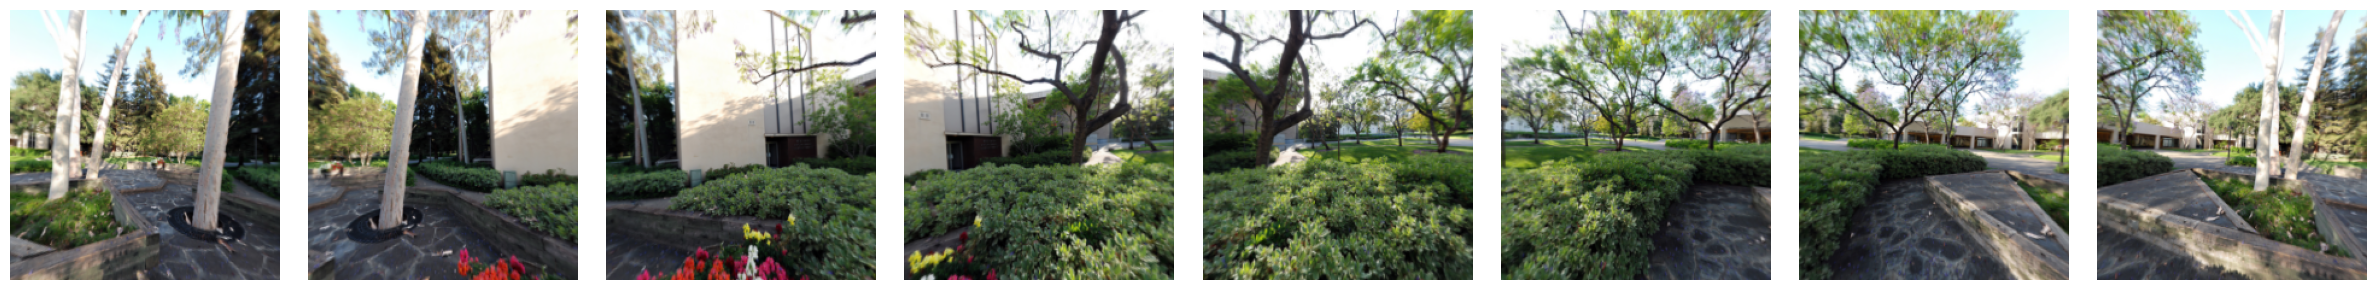

In [50]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from src.utils.viz import visualize_tensor_batch
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer
import torch
import numpy as np

processor = AutoProcessor.from_pretrained("facebook/dinov2-small")
print(processor)
tokenzier = AutoTokenizer.from_pretrained("google/gemma-3-4b-it")
img = Image.open("data/quic360/downtest/images/540231919_58d07745aa_o.jpg").convert("RGB")
img = img.resize((224*4, 224*2), Image.BILINEAR)
img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # (1, C, H2, W4)
dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= processor,
    tokenizer=tokenzier,
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
imgs = dataset.crop_equirectangular_tensor(img_tensor)
visualize_tensor_batch(imgs)
sample = processor(images=imgs, return_tensors="pt")
model = AutoModel.from_pretrained('facebook/dinov2-small',cache_dir='./.cache')
outputs = model(sample['pixel_values'])
last_hidden_states = outputs.last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()  

### 무변환 크롭 특징 추출

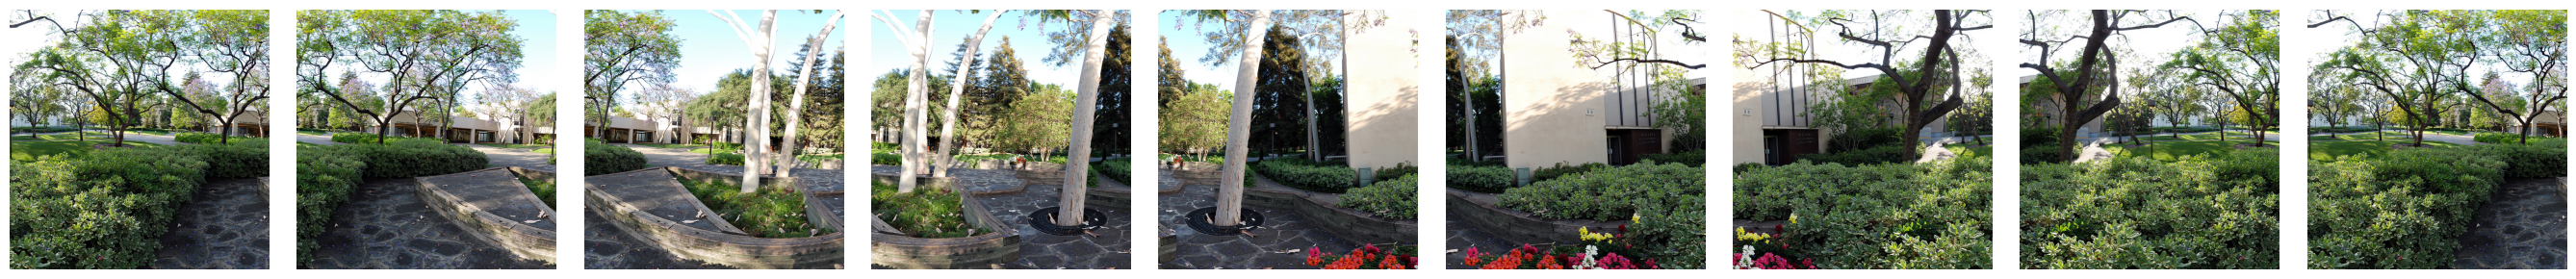

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
# from train import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer
from src.utils.viz import visualize_tensor_batch

processor = AutoProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained('facebook/dinov2-small',cache_dir='./.cache')
img = Image.open("data/quic360/downtest/images/540231919_58d07745aa_o.jpg").convert("RGB")
imgs = extract_sliding_patches(
    pil_img=img,
    fov=90.0,
    overlap_ratio=0.5
)
visualize_tensor_batch(imgs)
sample = processor(
    images=imgs,
    return_tensors="pt",
)

outputs = model(sample['pixel_values'])
last_hidden_states = outputs.last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()  

### 큐브맵 변환 특징추출

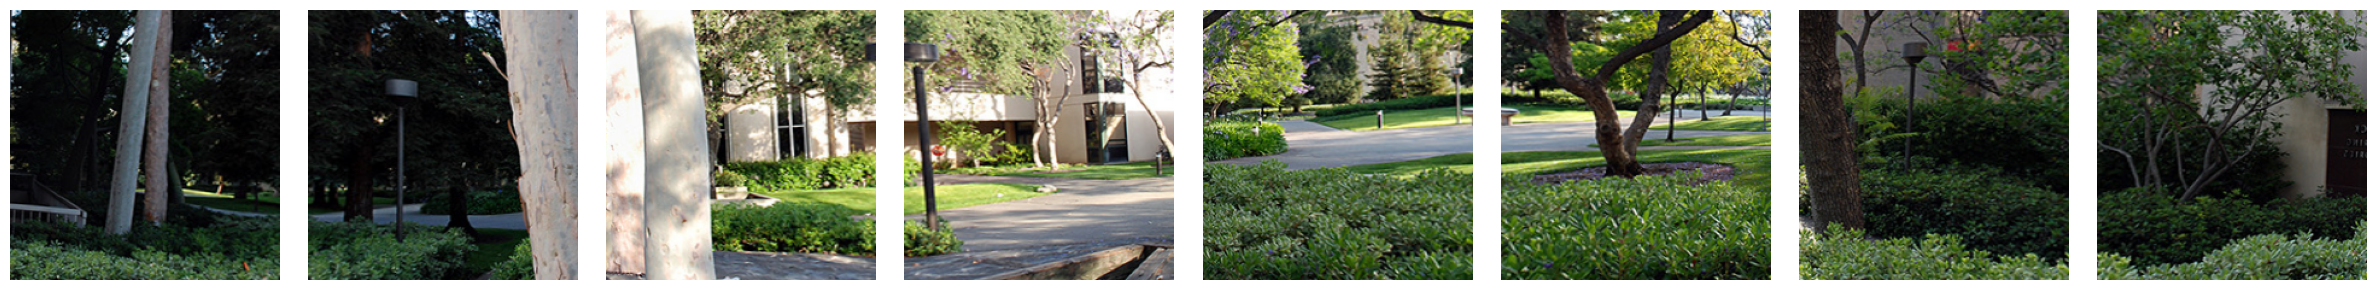

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
from src.utils.viz import visualize_tensor_batch
# from train import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer

processor = AutoProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained('facebook/dinov2-small',cache_dir='./.cache')
img = Image.open("data/quic360/downtest/images/540231919_58d07745aa_o.jpg").convert("RGB")

imgs = extract_edge_patches_from_panorama(
    pil_img=img,
    patch_size=224
)
visualize_tensor_batch(imgs)
sample = processor(
    images=imgs,
    return_tensors="pt",
)

outputs = model(sample['pixel_values'])
last_hidden_states = outputs.last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()  

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
# from train import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer



processor = AutoProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained('facebook/dinov2-small',cache_dir='./.cache')
img = Image.open("data/quic360/downtest/images/540231919_58d07745aa_o.jpg").convert("RGB")
imgs = extract_sliding_patches(
    pil_img=img,
    fov=90.0,
    overlap_ratio=0.5
)
sample = processor(
    images=imgs,
    return_tensors="pt",
)

outputs = model(sample['pixel_values'])
last_hidden_states = outputs.last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()  

### 제안하는 SurroundBlip 시각화

In [1]:
from src.models.surroundblip import SurroundBlip
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer

dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b",cache_dir='./.cache'),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]

model = SurroundBlip.from_pretrained("Salesforce/blip2-opt-2.7b", cache_dir='./.cache')
model = model.vision_model
model.eval()

last_hidden_states = model(sample['pixel_values']).last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()

c:\Users\Seungwoo\.conda\envs\surr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-27 20:55:09,941] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


W0527 20:55:10.561000 17568 torch\distributed\elastic\multiprocessing\redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\Seungwoo\.conda\envs\surr\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Seungwoo\.cache\huggingface\hub\models--Qwen--Qwen3-0.6B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details,

image_size: (448, 896)
[train] img_size=(448, 896)  do_crop=True
Input sequence:
<|im_start|>system
You are a helpful assistant. Describe this image.<|im_end|>
<|im_start|>user
location <image><image><|im_end|>
<|im_start|>assistant
<think>

</think>

A construction business that was operating in a dessert area, the company now looks to be abandon,   In the distance a crane stands watch over the business.<|im_end|>
<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

c:\Users\Seungwoo\.conda\envs\surr\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `BlipImageProcessor.preprocess` and were ignored: 'do_center_crop'
  return self.preprocess(images, **kwargs)


init_ query_tokens torch.Size([1, 32, 768])


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


In [ ]:
import os
# 사용할 GPU 번호 지정 (export CUDA_VISIBLE_DEVICES=1 과 동일)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
from src.models.surroundblip import SurroundBlip
from train_vlm import QuIC360Dataset
from transformers import AutoProcessor, AutoTokenizer

dataset = QuIC360Dataset(
    csv_file="data/quic360/downtest.csv",
    image_processor= AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b",cache_dir='./.cache'),
    tokenizer=AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B"),
    image_size=[224, 224],
    max_length=128,
    do_crop=True,
    fov=90,
    overlap_ratio=0.5,
)
sample = dataset[0]

model = SurroundBlip.from_pretrained(
    "saved_models/surround_360_add_vicloss",
    local_files_only=True  # 로컬 파일만 사용하도록 강제
)
model = model.vision_model
model.eval()

last_hidden_states = model(sample['pixel_values']).last_hidden_state
last_hidden_states = last_hidden_states.cpu().detach().numpy()

In [2]:
print(last_hidden_states.shape)  # Should print (batch_size, sequence_length, hidden_size)

(8, 257, 1408)


### 시각화

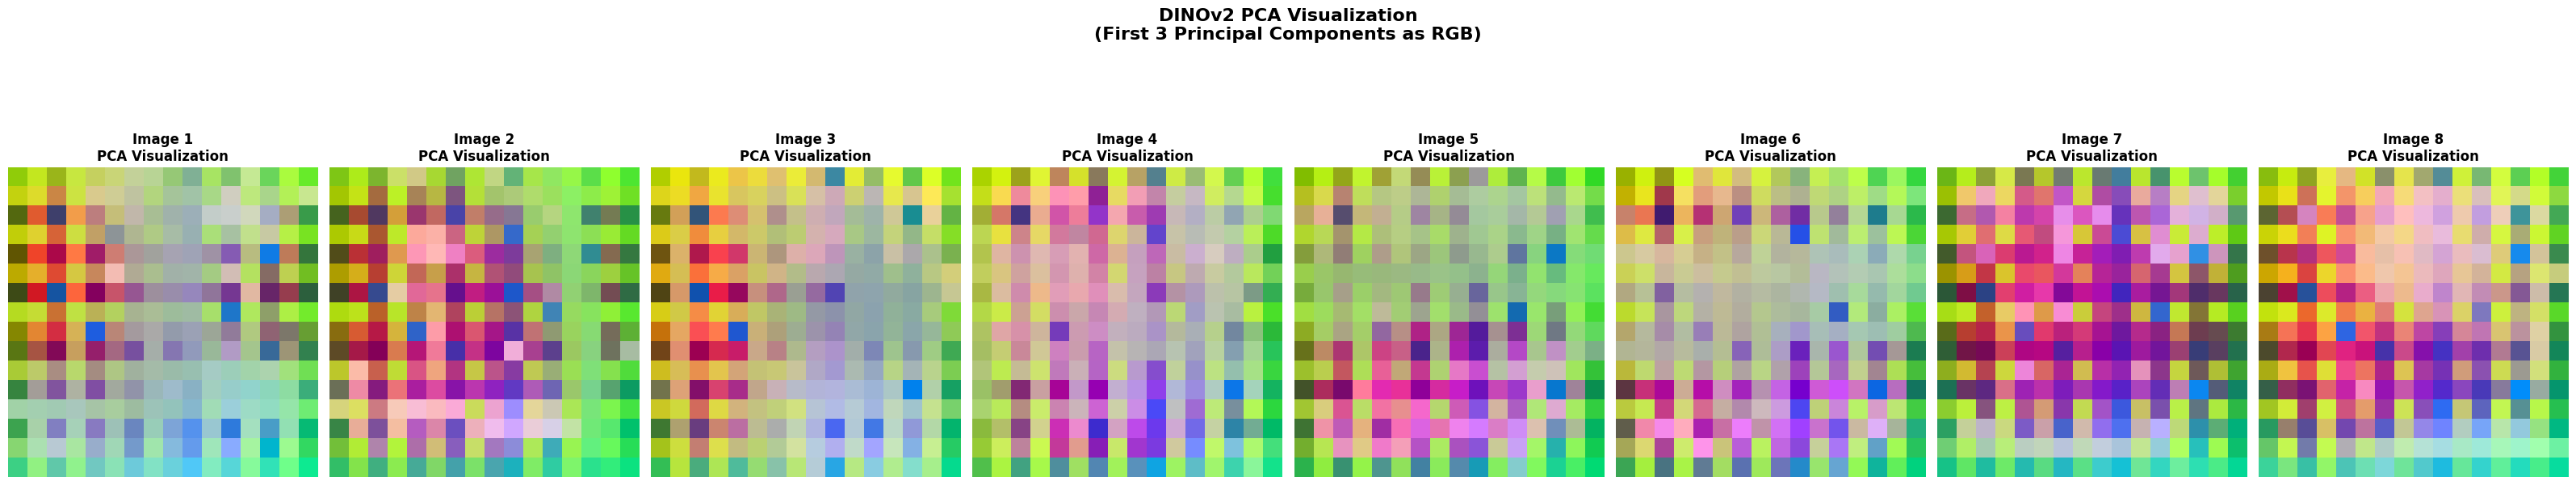


=== PCA 분석 결과 ===
주성분 1 설명 분산: 19.68%
주성분 2 설명 분산: 13.05%
주성분 3 설명 분산: 10.25%
총 설명 분산: 42.98%


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def dinov2_multiple_pca_visualization(hidden_states_list, remove_cls_token=True, use_background_removal=True):
    """
    여러 이미지의 DINOv2 hidden states에서 공통 PCA 기반 RGB 시각화 생성
    
    Args:
        hidden_states_list (list): Hidden states 리스트 
                                  각 원소는 [seq_len, hidden_dim] 또는 [batch_size, seq_len, hidden_dim]
        remove_cls_token (bool): CLS 토큰 제거 여부
        use_background_removal (bool): 배경 제거 적용 여부
        
    Returns:
        list: RGB 시각화 이미지들의 리스트 [patch_h, patch_w, 3]
    """
    
    # 1. 모든 hidden states 전처리
    all_patch_tokens = []
    processed_tokens_list = []
    
    for hidden_states in hidden_states_list:
        # 배치 차원 처리
        if hidden_states.ndim == 3:
            hidden_states = hidden_states[0]
        
        # CLS 토큰 제거
        if remove_cls_token:
            patch_tokens = hidden_states[1:]
        else:
            patch_tokens = hidden_states
        
        processed_tokens_list.append(patch_tokens)
        all_patch_tokens.append(patch_tokens)
    
    # 2. 모든 패치 토큰 결합 (공통 PCA를 위해)
    combined_tokens = np.vstack(all_patch_tokens)
    
    # 3. 배경 제거 (선택적)
    if use_background_removal:
        # 1차 PCA로 배경/전경 분리
        pca_bg = PCA(n_components=1)
        bg_component = pca_bg.fit_transform(combined_tokens)
        
        # 경험적 임계값으로 전경 마스크 생성
        foreground_mask = bg_component.flatten() > 0.6
        
        if np.sum(foreground_mask) > 0:
            foreground_tokens = combined_tokens[foreground_mask]
        else:
            foreground_tokens = combined_tokens
    else:
        foreground_tokens = combined_tokens
    
    # 4. 공통 PCA 모델 학습 (첫 3개 성분)
    pca_semantic = PCA(n_components=3)
    pca_semantic.fit(foreground_tokens)
    
    # 5. 각 이미지별로 PCA 변환 및 RGB 시각화 생성
    pca_rgb_list = []
    
    for patch_tokens in processed_tokens_list:
        # 공통 PCA 모델로 변환
        semantic_features = pca_semantic.transform(patch_tokens)
        
        # RGB 정규화 [0, 1]
        rgb_features = np.zeros_like(semantic_features)
        for i in range(3):
            component = semantic_features[:, i]
            min_val, max_val = component.min(), component.max()
            if max_val != min_val:
                rgb_features[:, i] = (component - min_val) / (max_val - min_val)
            else:
                rgb_features[:, i] = 0.5
        
        # 패치 격자로 재구성
        num_patches = len(patch_tokens)
        patch_size = int(np.sqrt(num_patches))
        
        pca_rgb = rgb_features.reshape(patch_size, patch_size, 3)
        pca_rgb_list.append(pca_rgb)
    
    return pca_rgb_list, pca_semantic

def visualize_multiple_pca_results(hidden_states_list, titles=None, save_path=None, figsize=None):
    """
    여러 이미지의 PCA 결과를 동시에 시각화 (DINOv2 논문 Figure 1 스타일)
    
    Args:
        hidden_states_list (list): Hidden states 리스트
        titles (list, optional): 각 이미지의 제목
        save_path (str, optional): 저장 경로
        figsize (tuple, optional): 그림 크기
        
    Returns:
        tuple: (pca_rgb_list, pca_model)
    """
    
    num_images = len(hidden_states_list)
    
    # 기본 설정
    if titles is None:
        titles = [f'Image {i+1}' for i in range(num_images)]
    
    if figsize is None:
        figsize = (4 * num_images, 8)
    
    # PCA 수행
    pca_rgb_list, pca_model = dinov2_multiple_pca_visualization(hidden_states_list)
    
    # 시각화
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    
    # 단일 이미지인 경우 axes를 리스트로 변환
    if num_images == 1:
        axes = [axes]
    
    for i, (pca_rgb, title) in enumerate(zip(pca_rgb_list, titles)):
        axes[i].imshow(pca_rgb)
        axes[i].set_title(f'{title}\nPCA Visualization', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('DINOv2 PCA Visualization\n(First 3 Principal Components as RGB)', 
                 fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"시각화 저장: {save_path}")
    
    plt.show()
    
    # PCA 분석 정보 출력
    explained_variance = pca_model.explained_variance_ratio_
    print(f"\n=== PCA 분석 결과 ===")
    print(f"주성분 1 설명 분산: {explained_variance[0]:.2%}")
    print(f"주성분 2 설명 분산: {explained_variance[1]:.2%}")
    print(f"주성분 3 설명 분산: {explained_variance[2]:.2%}")
    print(f"총 설명 분산: {np.sum(explained_variance):.2%}")
    
    return pca_rgb_list, pca_model

def compare_images_pca(hidden_states_list, original_images=None, titles=None, save_path=None):
    """
    원본 이미지와 PCA 시각화를 함께 비교 표시
    
    Args:
        hidden_states_list (list): Hidden states 리스트
        original_images (list, optional): 원본 이미지들 (PIL Image 또는 numpy array)
        titles (list, optional): 각 이미지의 제목
        save_path (str, optional): 저장 경로
    """
    
    num_images = len(hidden_states_list)
    
    if titles is None:
        titles = [f'Image {i+1}' for i in range(num_images)]
    
    # PCA 수행
    pca_rgb_list, pca_model = dinov2_multiple_pca_visualization(hidden_states_list)
    
    # 원본 이미지가 있는 경우 2행으로, 없는 경우 1행으로 구성
    if original_images is not None:
        fig, axes = plt.subplots(2, num_images, figsize=(4 * num_images, 8))
        
        # 단일 이미지인 경우 처리
        if num_images == 1:
            axes = axes.reshape(2, 1)
        
        # 원본 이미지 표시
        for i, (orig_img, title) in enumerate(zip(original_images, titles)):
            axes[0, i].imshow(orig_img)
            axes[0, i].set_title(f'{title}\nOriginal', fontsize=12)
            axes[0, i].axis('off')
        
        # PCA 시각화 표시
        for i, (pca_rgb, title) in enumerate(zip(pca_rgb_list, titles)):
            axes[1, i].imshow(pca_rgb)
            axes[1, i].set_title(f'{title}\nPCA Visualization', fontsize=12)
            axes[1, i].axis('off')
    
    else:
        # PCA 시각화만 표시
        fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
        
        if num_images == 1:
            axes = [axes]
        
        for i, (pca_rgb, title) in enumerate(zip(pca_rgb_list, titles)):
            axes[i].imshow(pca_rgb)
            axes[i].set_title(f'{title}\nPCA Visualization', fontsize=12, fontweight='bold')
            axes[i].axis('off')
    
    plt.suptitle('blip2 Semantic Feature Visualization', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"비교 시각화 저장: {save_path}")
    
    plt.show()
    
    return pca_rgb_list, pca_model

# 예제 1: 기본 여러 이미지 PCA 시각화

hidden_states_list = last_hidden_states
pca_results, pca_model = visualize_multiple_pca_results(
    hidden_states_list, 
)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

def calculate_patch_correspondence(hidden_states_1, hidden_states_2, overlap_ratio=0.5, 
                                remove_cls_token=True, similarity_metric='cosine'):
    """
    두 이미지의 겹치는 영역에서 패치별 특징 정합성을 계산
    
    Args:
        hidden_states_1, hidden_states_2: 두 이미지의 hidden states [seq_len, hidden_dim]
        overlap_ratio (float): 겹치는 비율 (예: 0.5 = 50%)
        remove_cls_token (bool): CLS 토큰 제거 여부
        similarity_metric (str): 유사도 메트릭 ('cosine', 'euclidean', 'dot_product')
        
    Returns:
        dict: 정합성 분석 결과
    """
    
    # 전처리
    def preprocess_hidden_states(hidden_states):
        if hidden_states.ndim == 3:
            hidden_states = hidden_states[0]
        if remove_cls_token:
            return hidden_states[1:]
        return hidden_states
    
    patches_1 = preprocess_hidden_states(hidden_states_1)
    patches_2 = preprocess_hidden_states(hidden_states_2)
    
    # 패치 격자 크기 계산
    num_patches = len(patches_1)
    patch_size = int(np.sqrt(num_patches))
    
    # 겹치는 영역 정의 (중앙 기준으로 overlap_ratio만큼)
    overlap_patches = int(patch_size * overlap_ratio)
    start_idx = (patch_size - overlap_patches) // 2
    end_idx = start_idx + overlap_patches
    
    # 겹치는 영역의 패치 인덱스 추출
    overlap_indices = []
    for i in range(start_idx, end_idx):
        for j in range(start_idx, end_idx):
            patch_idx = i * patch_size + j
            overlap_indices.append(patch_idx)
    
    # 겹치는 영역의 특징 추출
    overlap_features_1 = patches_1[overlap_indices]
    overlap_features_2 = patches_2[overlap_indices]
    
    # 유사도 계산
    if similarity_metric == 'cosine':
        # 각 패치별 코사인 유사도
        similarities = []
        for f1, f2 in zip(overlap_features_1, overlap_features_2):
            sim = cosine_similarity([f1], [f2])[0, 0]
            similarities.append(sim)
        similarities = np.array(similarities)
        
    elif similarity_metric == 'euclidean':
        # 유클리드 거리 (작을수록 유사)
        distances = np.linalg.norm(overlap_features_1 - overlap_features_2, axis=1)
        # 거리를 유사도로 변환 (0~1 범위)
        max_dist = np.max(distances)
        similarities = 1 - (distances / max_dist) if max_dist > 0 else np.ones_like(distances)
        
    elif similarity_metric == 'dot_product':
        # 내적 유사도 (정규화된)
        norm_f1 = overlap_features_1 / np.linalg.norm(overlap_features_1, axis=1, keepdims=True)
        norm_f2 = overlap_features_2 / np.linalg.norm(overlap_features_2, axis=1, keepdims=True)
        similarities = np.sum(norm_f1 * norm_f2, axis=1)
    
    # 통계 계산
    mean_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    min_similarity = np.min(similarities)
    max_similarity = np.max(similarities)
    
    # 공간적 정합성 맵 생성
    similarity_map = similarities.reshape(overlap_patches, overlap_patches)
    
    results = {
        'similarities': similarities,
        'similarity_map': similarity_map,
        'mean_similarity': mean_similarity,
        'std_similarity': std_similarity,
        'min_similarity': min_similarity,
        'max_similarity': max_similarity,
        'overlap_ratio': overlap_ratio,
        'num_overlap_patches': len(overlap_indices),
        'overlap_indices': overlap_indices,
        'metric': similarity_metric
    }
    
    return results

def visualize_correspondence_analysis(correspondence_results, title_prefix=""):
    """
    특징 정합성 분석 결과를 시각화
    
    Args:
        correspondence_results (dict): calculate_patch_correspondence 결과
        title_prefix (str): 제목 접두사
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. 유사도 히스토그램
    axes[0, 0].hist(correspondence_results['similarities'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(correspondence_results['mean_similarity'], color='red', linestyle='--', 
                      label=f'평균: {correspondence_results["mean_similarity"]:.3f}')
    axes[0, 0].set_xlabel('유사도')
    axes[0, 0].set_ylabel('빈도')
    axes[0, 0].set_title('패치별 특징 유사도 분포')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 공간적 유사도 맵
    im = axes[0, 1].imshow(correspondence_results['similarity_map'], cmap='viridis', vmin=0, vmax=1)
    axes[0, 1].set_title('공간적 특징 정합성 맵')
    axes[0, 1].set_xlabel('패치 열 인덱스')
    axes[0, 1].set_ylabel('패치 행 인덱스')
    plt.colorbar(im, ax=axes[0, 1], label='유사도')
    
    # 3. 박스 플롯
    axes[1, 0].boxplot(correspondence_results['similarities'], vert=True)
    axes[1, 0].set_ylabel('유사도')
    axes[1, 0].set_title('특징 유사도 분포 (박스플롯)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 통계 정보 텍스트
    stats_text = f"""
정합성 분석 통계
─────────────────
평균 유사도: {correspondence_results['mean_similarity']:.4f}
표준편차: {correspondence_results['std_similarity']:.4f}
최소값: {correspondence_results['min_similarity']:.4f}
최대값: {correspondence_results['max_similarity']:.4f}

겹침 비율: {correspondence_results['overlap_ratio']*100:.1f}%
분석 패치 수: {correspondence_results['num_overlap_patches']}개
유사도 메트릭: {correspondence_results['metric']}
    """
    
    axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes, 
                    fontsize=11, verticalalignment='center', fontfamily='monospace')
    axes[1, 1].axis('off')
    
    plt.suptitle(f'{title_prefix}특징 정합성 분석 결과', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

def multi_image_correspondence_analysis(hidden_states_list, overlap_ratio=0.5, 
                                      similarity_metric='cosine', titles=None):
    """
    여러 이미지 쌍에 대한 특징 정합성 분석
    
    Args:
        hidden_states_list (list): Hidden states 리스트
        overlap_ratio (float): 겹침 비율
        similarity_metric (str): 유사도 메트릭
        titles (list): 이미지 제목들
        
    Returns:
        dict: 모든 쌍의 정합성 분석 결과
    """
    
    n_images = len(hidden_states_list)
    
    if titles is None:
        titles = [f'Image_{i+1}' for i in range(n_images)]
    
    # 모든 쌍에 대한 분석
    pairwise_results = {}
    similarity_matrix = np.zeros((n_images, n_images))
    
    for i in range(n_images):
        for j in range(i+1, n_images):
            pair_key = f"{titles[i]}_vs_{titles[j]}"
            
            # 정합성 계산
            result = calculate_patch_correspondence(
                hidden_states_list[i], hidden_states_list[j],
                overlap_ratio=overlap_ratio,
                similarity_metric=similarity_metric
            )
            
            pairwise_results[pair_key] = result
            
            # 대칭 행렬 채우기
            mean_sim = result['mean_similarity']
            similarity_matrix[i, j] = mean_sim
            similarity_matrix[j, i] = mean_sim
    
    # 대각선 채우기 (자기 자신과의 유사도 = 1)
    np.fill_diagonal(similarity_matrix, 1.0)
    
    # 전체 결과 시각화
    plt.figure(figsize=(10, 8))
    
    # 유사도 행렬 히트맵
    plt.subplot(2, 1, 1)
    sns.heatmap(similarity_matrix, annot=True, cmap='viridis', 
                xticklabels=titles, yticklabels=titles,
                vmin=0, vmax=1, fmt='.3f')
    plt.title('이미지 쌍별 평균 특징 정합성 행렬')
    
    # 쌍별 유사도 분포
    plt.subplot(2, 1, 2)
    all_similarities = []
    pair_labels = []
    
    for pair_key, result in pairwise_results.items():
        all_similarities.extend(result['similarities'])
        pair_labels.extend([pair_key] * len(result['similarities']))
    
    # 박스플롯으로 쌍별 분포 비교
    unique_pairs = list(pairwise_results.keys())
    pair_data = [pairwise_results[pair]['similarities'] for pair in unique_pairs]
    
    plt.boxplot(pair_data, labels=unique_pairs)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('유사도')
    plt.title('이미지 쌍별 특징 유사도 분포')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 종합 통계
    overall_stats = {
        'pairwise_results': pairwise_results,
        'similarity_matrix': similarity_matrix,
        'mean_pairwise_similarity': np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]),
        'std_pairwise_similarity': np.std(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]),
        'titles': titles,
        'overlap_ratio': overlap_ratio,
        'similarity_metric': similarity_metric
    }
    
    return overall_stats

# 사용 예제
def analyze_feature_correspondence(hidden_states_list, overlap_ratio=0.5, titles=None):
    """
    편리한 래퍼 함수: 특징 정합성 종합 분석
    """
    
    print("=== 특징 정합성 분석 시작 ===\n")
    
    # 다중 이미지 분석
    results = multi_image_correspondence_analysis(
        hidden_states_list, 
        overlap_ratio=overlap_ratio,
        titles=titles
    )
    
    print(f"전체 평균 정합성: {results['mean_pairwise_similarity']:.4f}")
    print(f"정합성 표준편차: {results['std_pairwise_similarity']:.4f}")
    print(f"분석된 겹침 비율: {overlap_ratio*100:.1f}%")
    
    # 개별 쌍 분석 (첫 번째 쌍 예시)
    if len(results['pairwise_results']) > 0:
        first_pair = list(results['pairwise_results'].keys())[0]
        first_result = results['pairwise_results'][first_pair]
        
        print(f"\n=== 세부 분석 예시: {first_pair} ===")
        visualize_correspondence_analysis(first_result, title_prefix=f"{first_pair} - ")
    
    return results

=== 특징 정합성 분석 시작 ===



IndexError: list index out of range